# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed
import ast

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

from tqdm import tqdm
from numba import jit

import scipy.constants
from scipy.sparse import csr_matrix, csgraph

In [2]:
import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [3]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

GAUSS = 1e-4 # T
B = np.concatenate([np.arange(0.001,100,0.1),np.arange(100,500,1),np.arange(500,1001,10)]) * GAUSS

B_STEPS = len(B)
B_MIN = B[0]
B_MAX= B[-1]

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}'

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2
F_D_MAX = 2*N_MAX + I1_D + I2_D

# Generate canonical label & sparse edge ordering

In [4]:
UNCOUPLED_LABELS_D = []

for n in range(0, N_MAX + 1):
    for mn in range(n,-(n+1),-1):
        for mi1d in range(I1_D,-I1_D-1,-2):
            for mi2d in range(I2_D,-I2_D-1,-2):
                UNCOUPLED_LABELS_D.append((n,mn,mi1d,mi2d))

UNCOUPLED_LABELS_D = (np.rint(UNCOUPLED_LABELS_D)).astype("int")

In [5]:
generated_labels = np.zeros((N_STATES,3),dtype=int)
label_degeneracy_cache = np.zeros((N_MAX+1,F_D_MAX+1),dtype=int)
state_jump_list = np.zeros((N_MAX+1,F_D_MAX+1),dtype=int)

c=0
for N in range(0,N_MAX+1):
    F_D = 2*N + I1_D + I2_D
    for MF_D in range(-F_D,F_D+1,2):
        # Want number of ways of having
        # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
        d=0
        state_jump_list[N,(MF_D+F_D_MAX)//2]=c
        for MN in range(-N,N+1):
            for M_I1_D in range(-I1_D,I1_D+1,2):
                for M_I2_D in range(-I2_D,I2_D+1,2):
                    if 2*MN+M_I1_D+M_I2_D == MF_D:
                        generated_labels[c] = (N,MF_D,d)
                        d+=1
                        c+=1
        label_degeneracy_cache[N,(MF_D+F_D_MAX)//2]=d
        

def label_degeneracy(N,MF_D):
    return label_degeneracy_cache[N,(MF_D+F_D_MAX)//2]


def label_d_to_node_index(N,MF_D,d):
    return state_jump_list[N,(MF_D+F_D_MAX)//2]+d

In [6]:
generated_edge_labels = []
generated_edge_indices = []
edge_jump_list = []
for from_index, (N,MF_D,d_from) in enumerate(generated_labels):
    sub_jump_list = []
    sub_jump_list.append(len(generated_edge_labels))
    for dN in [1,-1]:
        for dMF_D in [0,-2*dN,2*dN]:
            if N>=N_MAX and dN==1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go higher
            if N<=0 and dN==-1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go lower
            if dN == -1:
                down_F_D =  2*(N-1) + I1_D + I2_D
                if MF_D+dMF_D > down_F_D or  MF_D+dMF_D < -down_F_D:
                    sub_jump_list.append(len(generated_edge_labels))
                    continue # lower state doesn't exist
            
            d_to = label_degeneracy(N+dN,MF_D+dMF_D)
            these_labels = []
            these_indices = []
            for k in range(d_to):
                these_labels.append((N,MF_D,d_from,N+dN,MF_D+dMF_D,k))
                these_indices.append((from_index,label_d_to_node_index(N+dN,MF_D+dMF_D,k)))
            generated_edge_labels.extend(these_labels)
            generated_edge_indices.extend(these_indices)
            sub_jump_list.append(len(generated_edge_labels))
            
    edge_jump_list.append(sub_jump_list)
    
N_TRANSITIONS = len(generated_edge_labels)

generated_edge_labels = np.array(generated_edge_labels,dtype=int)
generated_edge_indices = np.array(generated_edge_indices,dtype=int)
edge_jump_list = np.array(edge_jump_list,dtype=int)

def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return edge_jump_list[label_d_to_node_index(N,MF_D,d)]

In [7]:
INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = [label_d_to_node_index(*label_d) for label_d in INITIAL_STATE_LABELS_D]
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)

## Diagonalise & Calculate 

In [8]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=False)

H = (
    +H0[..., None]
    +Hz[..., None]*B
    ).transpose(2,0,1)

In [9]:
ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)

In [10]:
ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)

In [11]:
ENERGIES_before, STATES_before, labels_d = calculate.sort_by_state(ENERGIES_HALF_SORTED, STATES_HALF_SORTED, N_MAX, MOLECULE)

In [12]:
labels_d[:,1] *= 2 # Double MF to guarantee int
LABELS_D=(np.rint(labels_d)).astype("int")

In [13]:
canonical_to_energy_map = []
for N,MF_D,k in generated_labels:
    canonical_to_energy_map.append(np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0])
canonical_to_energy_map = np.array(canonical_to_energy_map)

In [14]:
ENERGIES = ENERGIES_before[:,canonical_to_energy_map].T
STATES = STATES_before[:,:,canonical_to_energy_map] #[b,uncoupled,coupled]

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


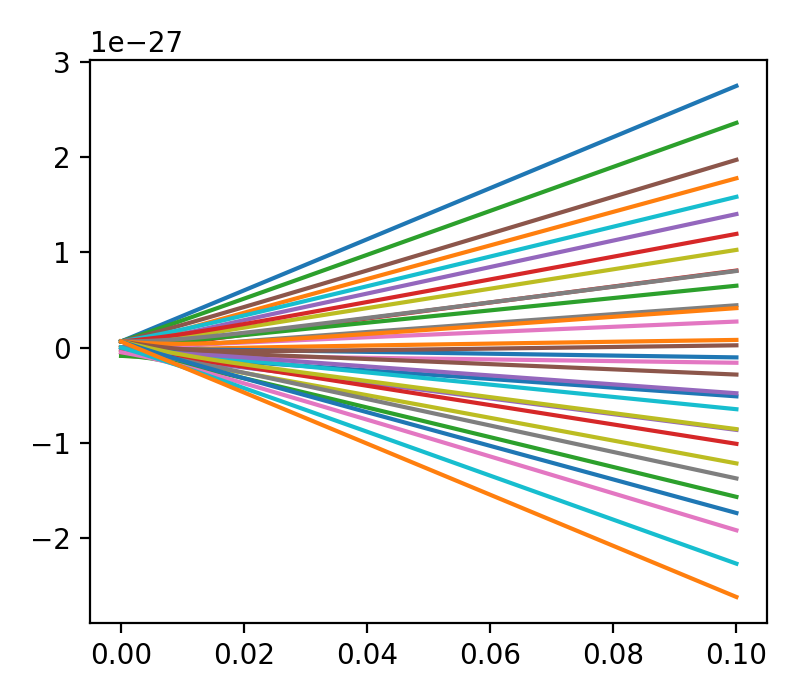

In [15]:
fig,ax = plt.subplots()
ax.plot(B,ENERGIES[0:32,:].T)

In [16]:
MAGNETIC_MOMENTS = np.einsum('bji,jk,bki->ib', STATES.conj(), -Hz, STATES, optimize='optimal')

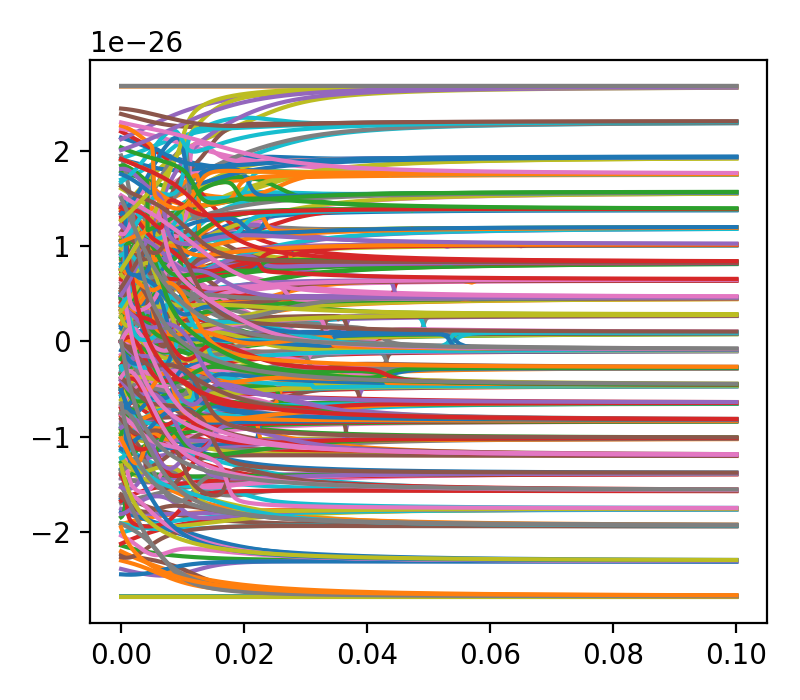

In [17]:
fig,ax = plt.subplots()
ax.plot(B,MAGNETIC_MOMENTS[0:,:].T);

In [18]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

In [19]:
                                           #[b,ci,ui]              [ui,uj]         #[b,uj,cj]
COUPLINGS_ZERO = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_zero @ STATES[:, :, :]
COUPLINGS_MINUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_minus @ STATES[:, :, :]
COUPLINGS_PLUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_plus @ STATES[:, :, :]

In [20]:
COUPLINGS_SPARSE = np.zeros((N_TRANSITIONS,B_STEPS),dtype=np.double)

for ii, (N,MF_D,d) in tqdm(enumerate(generated_labels),total=N_STATES):
    edge_indices = label_d_to_edge_indices(N,MF_D,d)

    up_zero = generated_edge_indices[edge_indices[0]:edge_indices[1],1]
    up_pos =  generated_edge_indices[edge_indices[1]:edge_indices[2],1]
    up_minus = generated_edge_indices[edge_indices[2]:edge_indices[3],1]
    down_zero = generated_edge_indices[edge_indices[3]:edge_indices[4],1]
    down_pos = generated_edge_indices[edge_indices[4]:edge_indices[5],1]
    down_minus = generated_edge_indices[edge_indices[5]:edge_indices[6],1]

    COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,ii,up_zero].T
    COUPLINGS_SPARSE[edge_indices[1]:edge_indices[2],:] = COUPLINGS_PLUS[:,ii,up_pos].T
    COUPLINGS_SPARSE[edge_indices[2]:edge_indices[3],:] = COUPLINGS_MINUS[:,ii,up_minus].T
    COUPLINGS_SPARSE[edge_indices[3]:edge_indices[4],:] = COUPLINGS_ZERO[:,ii,down_zero].T
    COUPLINGS_SPARSE[edge_indices[4]:edge_indices[5],:] = COUPLINGS_PLUS[:,ii,down_pos].T
    COUPLINGS_SPARSE[edge_indices[5]:edge_indices[6],:] = COUPLINGS_MINUS[:,ii,down_minus].T

  0%|                                                   | 0/288 [00:00<?, ?it/s]/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_49570/519505223.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,ii,up_zero].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_49570/519505223.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[1]:edge_indices[2],:] = COUPLINGS_PLUS[:,ii,up_pos].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_49570/519505223.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[2]:edge_indices[3],:] = COUPLINGS_MINUS[:,ii,up_minus].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_49570/519505223.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indice

In [21]:
test_indices = label_d_to_edge_indices(1,4,0)
i_n = 5
generated_edge_labels[test_indices[i_n]:test_indices[i_n+1]]

array([[1, 4, 0, 0, 2, 0],
       [1, 4, 0, 0, 2, 1],
       [1, 4, 0, 0, 2, 2],
       [1, 4, 0, 0, 2, 3]])

# Optimise for t_gate in each transition

In [22]:
T_G_UNPOL = np.zeros((N_TRANSITIONS,B_STEPS),dtype=np.double)
T_G_POL = np.zeros((N_TRANSITIONS,B_STEPS),dtype=np.double)
for i,label_pair in enumerate(generated_edge_labels):
    from_label = label_pair[0:3]
    to_label = label_pair[3:6]

    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label

    P=(to_label[0]-from_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == -2:
        section_index = 1
    elif P == 2:
        section_index = 2

    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]
    
    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    deltas_up   = np.abs(ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])/H_BAR
    deltas_down = np.abs(ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])/H_BAR
    
    deltas_up[up_node_indices == to_node_index,:] += 1e15
    deltas_down[down_node_indices == from_node_index,:] += 1e15
    
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)

    r_up_unpol = (4*gs_up**2 + gs_up**4)/(deltas_up**2)
    r_down_unpol = (4*gs_down**2 + gs_down**4)/(deltas_down**2)
    
    start_index_from = from_neighbours[0]
    start_index_to = to_neighbours[0]
    r_up_pol = r_up_unpol[from_neighbours[section_index]-start_index_from:from_neighbours[section_index+1]-start_index_from,:]
    r_down_pol = r_down_unpol[to_neighbours[section_index+3]-start_index_to:to_neighbours[section_index+4]-start_index_to,:]
    
    er_unpol = np.sqrt(np.sum(r_up_unpol,axis=0)+np.sum(r_down_unpol,axis=0))
    er_pol = np.sqrt(np.sum(r_up_pol,axis=0)+np.sum(r_down_pol,axis=0))
    
    T_G_UNPOL[i] = np.pi*er_unpol/4
    T_G_POL[i] = np.pi*er_pol/4

# Calculate Omegas for each pair

In [23]:
OMEGAS = np.zeros((N_TRANSITIONS,B_STEPS),dtype=np.double)

for i,label_pair in enumerate(generated_edge_labels):
    from_label = label_pair[0:3]
    to_label = label_pair[3:6]
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)
    
    delta = np.abs(ENERGIES[from_node_index,:] - ENERGIES[to_node_index,:])/H_BAR
    
    OMEGAS[i] = delta

In [24]:
posind = label_d_to_edge_indices(1,10,0)
OMEGAS[posind[0]:posind[6],0]

array([1.23189708e+10, 1.23193928e+10, 1.23202362e+10, 1.23204930e+10,
       1.23207300e+10, 1.23209633e+10, 1.23187492e+10, 1.23189708e+10,
       1.23193928e+10, 1.23199157e+10, 1.23201923e+10, 1.23202362e+10,
       1.23204930e+10, 1.23207300e+10, 1.23209633e+10, 1.23212821e+10,
       1.23193928e+10, 1.23207300e+10, 1.23209633e+10, 6.15845599e+09,
       6.15905349e+09, 6.15845598e+09])

In [25]:
len(generated_edge_labels)

10600

# Path from initial to any state

In [26]:
cumulative_unpol_fidelity_from_initials = np.zeros((B_STEPS,N_STATES),dtype=np.double)
predecessor_unpol_fidelity_from_initials = np.zeros((B_STEPS,N_STATES),dtype=int)

cumulative_pol_fidelity_from_initials = np.zeros((B_STEPS,N_STATES),dtype=np.double)
predecessor_pol_fidelity_from_initials = np.zeros((B_STEPS,N_STATES),dtype=int)

for bi in range(B_STEPS):
    distance_matrix = np.zeros((N_STATES,N_STATES))
    for i,(si,di) in enumerate(generated_edge_indices):
        distance_matrix[si,di] = T_G_UNPOL[i,bi]
    distance_matrix_csr = csr_matrix(distance_matrix)
    (distances_from_initials),(predecessors_from_initials) = csgraph.shortest_path(distance_matrix_csr,return_predecessors=True,directed=False,indices=INITIAL_STATE_INDICES)
    best_start = np.argmin(distances_from_initials,axis=0)
    cumulative_unpol_fidelity_from_initials[bi]=np.take_along_axis(distances_from_initials,np.expand_dims(best_start,axis=0),axis=0)
    predecessor_unpol_fidelity_from_initials[bi]=np.take_along_axis(predecessors_from_initials,np.expand_dims(best_start,axis=0),axis=0)
    
    distance_matrix = np.zeros((N_STATES,N_STATES))
    for i,(si,di) in enumerate(generated_edge_indices):
        distance_matrix[si,di] = T_G_POL[i,bi]
    distance_matrix_csr = csr_matrix(distance_matrix)
    (distances_from_initials),(predecessors_from_initials) = csgraph.shortest_path(distance_matrix_csr,return_predecessors=True,directed=False,indices=INITIAL_STATE_INDICES)
    best_start = np.argmin(distances_from_initials,axis=0)
    cumulative_pol_fidelity_from_initials[bi]=np.take_along_axis(distances_from_initials,np.expand_dims(best_start,axis=0),axis=0)
    predecessor_pol_fidelity_from_initials[bi]=np.take_along_axis(predecessors_from_initials,np.expand_dims(best_start,axis=0),axis=0)
    
cumulative_unpol_fidelity_from_initials = cumulative_unpol_fidelity_from_initials.T
predecessor_unpol_fidelity_from_initials = predecessor_unpol_fidelity_from_initials.T

cumulative_pol_fidelity_from_initials = cumulative_pol_fidelity_from_initials.T
predecessor_pol_fidelity_from_initials = predecessor_pol_fidelity_from_initials.T

# Save to files

In [27]:
np.savez_compressed(f'../precomputed/{settings_string}.npz',
                    b = B,
                    energies = ENERGIES,
                    states = STATES,
                    
                    uncoupled_labels_d = UNCOUPLED_LABELS_D,
                    
                    labels_d = generated_labels,
                    labels_degeneracy = label_degeneracy_cache,
                    state_jump_list = state_jump_list,
                    
                    transition_labels_d = generated_edge_labels,
                    transition_indices = generated_edge_indices, 
                    edge_jump_list = edge_jump_list,
                    
                    magnetic_moments = MAGNETIC_MOMENTS,
                    
                    couplings_sparse = COUPLINGS_SPARSE,
                    transition_gate_times_pol = T_G_POL,
                    transition_gate_times_unpol = T_G_UNPOL,
                    
                    pair_resonance = OMEGAS,
                    
                    cumulative_unpol_time_from_initials = cumulative_unpol_fidelity_from_initials,
                    predecessor_unpol_time_from_initials = predecessor_unpol_fidelity_from_initials,
                    cumulative_pol_time_from_initials = cumulative_pol_fidelity_from_initials,
                    predecessor_pol_time_from_initials = predecessor_pol_fidelity_from_initials,
                   )

# How to load file
Copy 'Defining Parameters' and 'Computed Constants' section, then load the file from computed `settings_string`.

In [28]:
data = np.load(f'../precomputed/{settings_string}.npz')
energies_loaded = data['energies']
print(energies_loaded.shape)

(288, 1451)
